<a href="https://colab.research.google.com/github/Elwing-Chou/tibaml0922/blob/main/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import zipfile
f = zipfile.ZipFile("/content/drive/MyDrive/additional/train.zip")
f.extractall()

In [59]:
import glob
import pandas as pd
dogs = glob.glob("train/dog.*")
cats = glob.glob("train/cat.*")
df = pd.DataFrame({
    "path":dogs + cats,
    "ans":[0] * len(dogs) + [1] * len(cats)
})
df

,path,ans
0,train/dog.5450.jpg,0
1,train/dog.1933.jpg,0
2,train/dog.8744.jpg,0
3,train/dog.2438.jpg,0
4,train/dog.5943.jpg,0
...,...,...
24995,train/cat.8920.jpg,1
24996,train/cat.1859.jpg,1
24997,train/cat.8150.jpg,1
24998,train/cat.8976.jpg,1


In [60]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))
for l in cnn.layers:
    l.trainable = False
layers = [
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
model = Sequential(cnn.layers + layers)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [61]:
# y: 做one-hot encoding很耗費ram, 直接使用Sparse省RAM又方便
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

[[[ -87.939    -106.779    -120.68    ]
  [ -80.939     -99.779    -113.68    ]
  [ -78.939     -97.779    -111.68    ]
  ...
  [-102.939    -112.779    -123.68    ]
  [-102.939    -112.779    -123.68    ]
  [-101.939    -111.779    -123.68    ]]

 [[ -85.939    -104.779    -118.68    ]
  [ -82.939    -101.779    -114.68    ]
  [ -80.939    -100.779    -114.68    ]
  ...
  [ -94.939    -104.779    -120.68    ]
  [ -94.939    -104.779    -119.68    ]
  [ -93.939    -103.779    -118.68    ]]

 [[ -85.939    -104.779    -118.68    ]
  [ -86.939    -105.779    -119.68    ]
  [ -85.939    -105.779    -120.68    ]
  ...
  [ -88.939     -98.779    -114.68    ]
  [ -85.939     -95.779    -112.68    ]
  [ -85.939     -95.779    -111.68    ]]

 ...

 [[-100.939    -113.779    -120.68    ]
  [-100.939    -113.779    -120.68    ]
  [-100.939    -113.779    -120.68    ]
  ...
  [ -68.939     -75.779    -101.68    ]
  [ -69.939     -76.779    -102.68    ]
  [ -69.939     -76.779    -102.68    ]]

 [

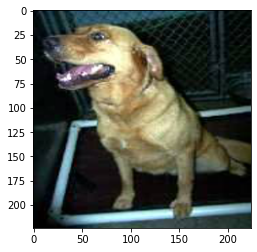

In [62]:
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

p = df["path"]
idx = random.randint(0, len(p)-1)
img = Image.open(p[idx]).resize((224, 224)).convert("RGB")
img_np = np.array(img)
img_np_pre = preprocess_input(img_np)
print(img_np_pre)
plt.imshow(img)

In [63]:
x = np.array(df["path"])
y = np.array(df["ans"])

In [64]:
def data_generator(x, y, batch_size=20):
    while True:
        idx = np.random.randint(0, len(x), size=batch_size)
        x_batch, y_batch = x[idx], y[idx]
        x_final = []
        for path in x_batch:
            img = Image.open(path).resize((224, 224)).convert("RGB")
            img_pre = preprocess_input(np.array(img))
            x_final.append(img_pre)
        x_final = np.array(x_final)
        y_batch = np.array(y_batch)
        yield (x_final, y_batch)
gen = data_generator(x, y)
x_gen, y_gen = gen.__next__()
print(x_gen.shape)
print(y_gen.shape)
# print(x_gen)
# print(y_gen)

(20, 224, 224, 3)
(20,)


In [65]:
from sklearn.model_selection import train_test_split
dogx = x[y == 0]
catx = x[y == 1]
dog1000 = np.random.choice(dogx, 1000, replace=False)
dog900, dog100 = train_test_split(dog1000, test_size=0.1)
cat1000 = np.random.choice(catx, 1000, replace=False)
cat900, cat100 = train_test_split(cat1000, test_size=0.1)
x_train = np.concatenate((dog900, cat900))
y_train = np.array([0] * len(dog900) + [1] * len(cat900))
x_test = np.concatenate((dog100, cat100))
y_test = np.array([0] * len(dog100) + [1] * len(cat100))
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1800,)
(200,)
(1800,)
(200,)


In [77]:
train_generator = data_generator(x_train, y_train)
test_generator = data_generator(x_test, y_test, batch_size=50)

In [78]:
# 50 * 20 -> 訓練
# 5 * 20 -> 測試
model.fit_generator(train_generator,
                    steps_per_epoch=50,
                    epochs=2,
                    validation_data=test_generator.__next__())

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
50/50 [==============================] - 24s 494ms/step - loss: 0.0357 - accuracy: 0.9870 - val_loss: 0.1645 - val_accuracy: 0.9600
Epoch 2/2
50/50 [==============================] - 12s 238ms/step - loss: 0.0253 - accuracy: 0.9910 - val_loss: 0.2344 - val_accuracy: 0.9600
